In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from transformers import TFAutoModel, AutoTokenizer


In [ ]:
import pandas as pd


# Load datasets
news_data = pd.read_csv("/content/SMP(News for day).csv")  # News dataset with 'Date' and 'News'
historical_data = pd.read_csv("/content/SMP (Day).csv")  # Historical stock data with 'Date' and features

# Preview datasets
print(news_data.head())  # Should contain 'Date' and 'News'
print(historical_data.head())  # Should contain 'Date' and stock features


         Date                                               News
0  2021-01-24  As per Regulation 161 of the Dhaka Stock Excha...
1  2021-01-31  Consolidated EPS was Tk. 1.52 for OctoberDecem...
2  2021-04-05  The company has informed that Power Purchase A...
3  2021-04-26  As per Regulation 161 of the Dhaka Stock Excha...
4  2021-05-02  Consolidated EPS was Tk. 1.36 for JanuaryMarch...
         Date  Price  Open  High   Low      Vol.
0  2024-12-30   14.8  15.0  15.0  14.7  267490.0
1  2024-12-29   14.9  15.0  15.1  14.8  169120.0
2  2024-12-26   15.0  15.0  15.5  14.9  278230.0
3  2024-12-24   15.2  15.5  15.5  15.0  183200.0
4  2024-12-23   15.2  15.8  15.8  15.2  273820.0


In [ ]:
news_data = news_data.iloc[::-1].reset_index(drop=True)
news_data = news_data.dropna()
news_data = news_data.reset_index(drop=True)

In [ ]:
historical_data.head(5)

,Date,Price,Open,High,Low,Vol.
0,2024-12-30,14.8,15.0,15.0,14.7,267490.0
1,2024-12-29,14.9,15.0,15.1,14.8,169120.0
2,2024-12-26,15.0,15.0,15.5,14.9,278230.0
3,2024-12-24,15.2,15.5,15.5,15.0,183200.0
4,2024-12-23,15.2,15.8,15.8,15.2,273820.0


In [ ]:
# Convert dates to datetime
news_data['Date'] = pd.to_datetime(news_data['Date'])
historical_data['Date'] = pd.to_datetime(historical_data['Date'])

# Ensure both datasets are sorted by date
news_data = news_data.sort_values('Date').reset_index(drop=True)
historical_data = historical_data.sort_values('Date').reset_index(drop=True)

print(news_data.head())
print(historical_data.head())

        Date                                               News
0 2021-01-24  As per Regulation 161 of the Dhaka Stock Excha...
1 2021-01-31  Consolidated EPS was Tk. 1.52 for OctoberDecem...
2 2021-04-05  The company has informed that Power Purchase A...
3 2021-04-26  As per Regulation 161 of the Dhaka Stock Excha...
4 2021-05-02  Consolidated EPS was Tk. 1.36 for JanuaryMarch...
        Date  Price  Open  High   Low       Vol.
0 2021-01-03   41.2  39.7  41.6  39.4  1880000.0
1 2021-01-04   40.9  41.3  41.5  39.4  3790000.0
2 2021-01-05   43.1  41.1  44.6  41.1  6910000.0
3 2021-01-06   42.2  43.3  43.6  41.8  2460000.0
4 2021-01-07   41.2  42.4  42.9  41.1  2130000.0


In [ ]:
news_data = news_data.iloc[::-1].reset_index(drop=True)
news_data.head(10)

,Date,News
0,2024-12-29,The company has informed that the Bangladesh S...
1,2024-12-15,The company has provided updates regarding the...
2,2024-07-18,The Company has informed the Status of Operati...
3,2024-06-19,"In response to the DSE query, the company has ..."
4,2024-06-09,The Company has informed that it has disbursed...
5,2024-05-02,The company has informed that the Board of Dir...
6,2024-04-30,Consolidated EPS was Tk. 0.69 for JanuaryMarch...
7,2024-04-24,As per Regulation 161 of the Dhaka Stock Excha...
8,2024-04-04,Refer to their earlier news disseminated by DS...
9,2024-04-02,Credit Rating Information and Services Limited...


In [ ]:
historical_data = historical_data.iloc[::-1].reset_index(drop=True)
historical_data.head(10)

,Date,Price,Open,High,Low,Vol.
0,2024-12-30,14.8,15.0,15.0,14.7,267490.0
1,2024-12-29,14.9,15.0,15.1,14.8,169120.0
2,2024-12-26,15.0,15.0,15.5,14.9,278230.0
3,2024-12-24,15.2,15.5,15.5,15.0,183200.0
4,2024-12-23,15.2,15.8,15.8,15.2,273820.0
5,2024-12-22,15.4,15.6,15.8,15.3,228000.0
6,2024-12-19,15.6,15.8,15.8,15.5,214500.0
7,2024-12-18,15.7,16.3,16.3,15.6,234000.0
8,2024-12-17,15.8,15.6,15.9,15.4,579480.0
9,2024-12-15,15.8,16.0,16.1,15.7,412440.0


In [ ]:
# For historical_data
historical_data.fillna(method='ffill', inplace=True)

<ipython-input-8-547101b32549>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_data.fillna(method='ffill', inplace=True)


In [ ]:
# For news_data
news_data_null_counts = news_data.isnull().sum()
print("Null values in news_data:\n", news_data_null_counts)

# For historical_data
historical_data_null_counts = historical_data.isnull().sum()
print("\nNull values in historical_data:\n", historical_data_null_counts)

Null values in news_data:
 Date    0
News    0
dtype: int64

Null values in historical_data:
 Date     0
Price    0
Open     0
High     0
Low      0
Vol.     0
dtype: int64


In [ ]:
SEQ_LEN = 90  # Number of days for historical data
HISTORICAL_FEATURES = 5  # Exclude 'Date'

# Normalize historical data
historical_data.iloc[:, 1:] = (historical_data.iloc[:, 1:] - historical_data.iloc[:, 1:].mean()) / historical_data.iloc[:, 1:].std()

# Prepare training data
train_samples = []

for i, news_row in news_data.iterrows():
    news_date = news_row['Date']

    # Check if the news_date exists in historical_data
    if news_date not in historical_data['Date'].values:
        continue  # Skip this news item if the date is not found in historical data

    # Get the corresponding 90-day window from historical data
    hist_index = historical_data[historical_data['Date'] == news_date].index[0]

    if hist_index >= SEQ_LEN - 1:
        historical_window = historical_data.iloc[hist_index - SEQ_LEN + 1:hist_index + 1, 1:].values

        # Collect all news within the 90-day window
        news_within_window = news_data[
            (news_data['Date'] >= historical_data.iloc[hist_index - SEQ_LEN + 1]['Date']) &
            (news_data['Date'] <= news_date)
        ]

        train_samples.append({
            'news': list(news_within_window['News']),
            'historical_data': historical_window,
            'target': historical_data.iloc[hist_index]['Price']  # Ensure 'Price' is the target column
        })

# Filter out samples with missing target values (if any)
train_samples = [sample for sample in train_samples if not np.isnan(sample['target'])]


In [ ]:
# ipython-input-34-59bf81bb6b6b
from transformers import AutoTokenizer

# Initialize FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

# Tokenize news data
max_length = 512

def tokenize_news(news_list):
    combined_text = " ".join(news_list)  # Combine all news items for the sample
    tokens = tokenizer(
        combined_text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="np"
    )
    return tokens['input_ids'][0], tokens['attention_mask'][0] #Squeeze the extra dimension

# Tokenize the news for each sample
news_input_ids = []
news_attention_masks = []
historical_inputs = []
targets = []

for sample in train_samples:
    input_ids, attention_mask = tokenize_news(sample['news'])
    news_input_ids.append(input_ids)
    news_attention_masks.append(attention_mask)
    historical_inputs.append(sample['historical_data'])
    targets.append(sample['target'])

news_input_ids = np.array(news_input_ids)
news_attention_masks = np.array(news_attention_masks)
historical_inputs = np.array(historical_inputs)
targets = np.array(targets)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets
X_news_train, X_news_test, X_news_mask_train, X_news_mask_test, \
X_historical_train, X_historical_test, y_train, y_test = train_test_split(
    news_input_ids, news_attention_masks, historical_inputs, targets,
    test_size=0.2, random_state=42
)

# Further split the training set into training and validation sets
X_news_train, X_news_val, X_news_mask_train, X_news_mask_val, \
X_historical_train, X_historical_val, y_train, y_val = train_test_split(
    X_news_train, X_news_mask_train, X_historical_train, y_train,
    test_size=0.2, random_state=42
)

In [ ]:
'''
from tensorflow.keras import layers
from transformers import TFBertModel
import tensorflow as tf

def build_multimodal_model():
    # Define input shapes
    seq_len = 512  # Updated sequence length
    hist_features = 5  # Number of historical stock features
    hist_seq_len = 90  # 90 days of historical stock data

    # Load FinBERT model
    finbert_model = TFBertModel.from_pretrained("yiyanghkust/finbert-tone")
    finbert_input_ids = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")
    finbert_attention_mask = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")

    # Wrap FinBERT call in a Lambda layer with explicit output shape
    finbert_output = tf.keras.layers.Lambda(
        lambda x: finbert_model(x[0], attention_mask=x[1]).last_hidden_state,
        output_shape=(seq_len, finbert_model.config.hidden_size)  # Add output shape here
    )([finbert_input_ids, finbert_attention_mask])

    # Extract the [CLS] token output (usually the first token)
    finbert_cls_output = finbert_output[:, 0, :]  # Get the output for the [CLS] token

    # Historical stock data input
    historical_input = tf.keras.layers.Input(shape=(hist_seq_len, hist_features), name="historical_input")

    # Transformer encoder for historical stock data
    hist_attention = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=hist_features)(historical_input, historical_input)
    hist_output = tf.keras.layers.GlobalAveragePooling1D()(hist_attention)

    # Combine news and historical features
    combined_features = tf.keras.layers.Concatenate()([finbert_cls_output, hist_output])

    # Fully connected layers
    x = tf.keras.layers.Dense(128, activation="relu")(combined_features)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(1, activation="linear", name="price_output")(x)

    # Define the final model
    model = tf.keras.Model(
        inputs=[finbert_input_ids, finbert_attention_mask, historical_input],
        outputs=output
    )
    return model

    '''

'\nfrom tensorflow.keras import layers\nfrom transformers import TFBertModel\nimport tensorflow as tf\n\ndef build_multimodal_model():\n    # Define input shapes\n    seq_len = 512  # Updated sequence length\n    hist_features = 5  # Number of historical stock features\n    hist_seq_len = 90  # 90 days of historical stock data\n\n    # Load FinBERT model\n    finbert_model = TFBertModel.from_pretrained("yiyanghkust/finbert-tone")\n    finbert_input_ids = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")\n    finbert_attention_mask = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")\n\n    # Wrap FinBERT call in a Lambda layer with explicit output shape\n    finbert_output = tf.keras.layers.Lambda(\n        lambda x: finbert_model(x[0], attention_mask=x[1]).last_hidden_state,\n        output_shape=(seq_len, finbert_model.config.hidden_size)  # Add output shape here\n    )([finbert_input_ids, finbert_attention_mask])\n\

In [ ]:

#Model 1
'''

from tensorflow.keras import layers, Model
from transformers import TFBertModel
import tensorflow as tf
from tensorflow.keras import regularizers


class FinBERTLayer(layers.Layer):
    def __init__(self, model_name="yiyanghkust/finbert-tone", **kwargs):
        super(FinBERTLayer, self).__init__(**kwargs)
        self.finbert = TFBertModel.from_pretrained(model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token


def build_multimodal_stock_model(seq_len=512, hist_features=5, hist_seq_len=90 , l2_lambda=0.001):
    # Inputs for textual data (FinBERT)
    finbert_input_ids = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")
    finbert_attention_mask = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")

    # FinBERT model wrapped in a custom layer
    finbert_output = FinBERTLayer()([finbert_input_ids, finbert_attention_mask])
    news_context_vector = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="news_dense")(finbert_output)

    # Inputs for numerical data (historical stock data)
    historical_input = layers.Input(shape=(hist_seq_len, hist_features), name="historical_input")

    # Transformer for historical stock data
    hist_transformer = layers.MultiHeadAttention(num_heads=4, key_dim=hist_features)(historical_input, historical_input)
    hist_context_vector = layers.GlobalAveragePooling1D()(hist_transformer)

    # Project historical context vector to the same dimension as FinBERT output (128)
    hist_context_projected = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="hist_dense")(hist_context_vector)

    # Cross-Attention-Based Fusion
    fusion = layers.MultiHeadAttention(num_heads=4, key_dim=128)(
        news_context_vector[:, tf.newaxis, :], hist_context_projected[:, tf.newaxis, :]
    )
    fusion = layers.GlobalAveragePooling1D()(fusion)

    # Dense or pooling layer
    combined_vector = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="fusion_dense")(fusion)
    combined_vector = layers.Dropout(0.2)(combined_vector)

    # Transformer for final prediction
    combined_transformer = layers.MultiHeadAttention(num_heads=4, key_dim=64)(
        combined_vector[:, tf.newaxis, :], combined_vector[:, tf.newaxis, :]
    )
    final_vector = layers.GlobalAveragePooling1D()(combined_transformer)

    # Output dense layer
    price_output = layers.Dense(1, activation="linear", kernel_regularizer=regularizers.l2(l2_lambda), name="price_output")(final_vector)

    # Build the model
    model = Model(
        inputs=[finbert_input_ids, finbert_attention_mask, historical_input],
        outputs=price_output,
    )

    return model
'''

'\n\nfrom tensorflow.keras import layers, Model\nfrom transformers import TFBertModel\nimport tensorflow as tf\nfrom tensorflow.keras import regularizers\n\n\nclass FinBERTLayer(layers.Layer):\n    def __init__(self, model_name="yiyanghkust/finbert-tone", **kwargs):\n        super(FinBERTLayer, self).__init__(**kwargs)\n        self.finbert = TFBertModel.from_pretrained(model_name)\n\n    def call(self, inputs):\n        input_ids, attention_mask = inputs\n        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)\n        return outputs.last_hidden_state[:, 0, :]  # CLS token\n\n\ndef build_multimodal_stock_model(seq_len=512, hist_features=5, hist_seq_len=90 , l2_lambda=0.001):\n    # Inputs for textual data (FinBERT)\n    finbert_input_ids = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")\n    finbert_attention_mask = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")\n\n    # FinBERT model wrapped in a custo

In [ ]:
from tensorflow.keras import layers, Model, optimizers
from transformers import TFBertModel
import tensorflow as tf
from tensorflow.keras import regularizers

def build_historical_transformer(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LayerNormalization()(inputs)

    # Transformer Encoder block
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)

    # Pooling and output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(128, activation='relu', name="hist_dense_transformed")(x)  # Match FinBERT output dimension

    model = tf.keras.Model(inputs, outputs)
    return model

class FinBERTLayer(layers.Layer):
    def __init__(self, model_name="yiyanghkust/finbert-tone", **kwargs):
        super(FinBERTLayer, self).__init__(**kwargs)
        self.finbert = TFBertModel.from_pretrained(model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

def build_multimodal_stock_model(seq_len=512, hist_features=5, hist_seq_len=90, l2_lambda=0.01, learning_rate=0.002):
    # Inputs for textual data (FinBERT)
    finbert_input_ids = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")
    finbert_attention_mask = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")

    # FinBERT model wrapped in a custom layer
    finbert_output = FinBERTLayer()([finbert_input_ids, finbert_attention_mask])
    news_context_vector = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="news_dense")(finbert_output)

    # Inputs for numerical data (historical stock data)
    historical_input = layers.Input(shape=(hist_seq_len, hist_features), name="historical_input")

    # Historical Transformer Model
    historical_transformer_model = build_historical_transformer((hist_seq_len, hist_features))
    hist_context_vector = historical_transformer_model(historical_input)

    # Cross-Attention-Based Fusion
    fusion = layers.MultiHeadAttention(num_heads=4, key_dim=128)(
        news_context_vector[:, tf.newaxis, :], hist_context_vector[:, tf.newaxis, :]
    )
    fusion = layers.GlobalAveragePooling1D()(fusion)

    # Dense or pooling layer
    combined_vector = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="fusion_dense")(fusion)
    combined_vector = layers.Dropout(0.2)(combined_vector)

    # Transformer for final prediction
    combined_transformer = layers.MultiHeadAttention(num_heads=4, key_dim=64)(
        combined_vector[:, tf.newaxis, :], combined_vector[:, tf.newaxis, :]
    )
    final_vector = layers.GlobalAveragePooling1D()(combined_transformer)

    # Output dense layer
    price_output = layers.Dense(1, activation="linear", kernel_regularizer=regularizers.l2(l2_lambda), name="price_output")(final_vector)

    # Build the model
    model = Model(
        inputs=[finbert_input_ids, finbert_attention_mask, historical_input],
        outputs=price_output,
    )

    # Compile the model with learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


In [ ]:
model = build_multimodal_stock_model()
model.compile(optimizer="adam", loss="mse", metrics=["mae"])



tf_model.h5:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Train the model
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(
    x=[X_news_train, X_news_mask_train, X_historical_train],
    y=y_train,
    validation_data=([X_news_val, X_news_mask_val, X_historical_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 48s 16s/step - loss: 3.7508 - mae: 0.5909 - val_loss: 3.6995 - val_mae: 0.6976
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step - loss: 3.4704 - mae: 0.5977 - val_loss: 3.2692 - val_mae: 0.5901
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - loss: 3.0704 - mae: 0.4975 - val_loss: 3.0259 - val_mae: 0.4817
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step - loss: 2.8137 - mae: 0.3962 - val_loss: 2.9623 - val_mae: 0.5945
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - loss: 2.7284 - mae: 0.4297 - val_loss: 2.5957 - val_mae: 0.4617
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - loss: 2.4801 - mae: 0.3698 - val_loss: 2.4017 - val_mae: 0.4389
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - loss: 2.3573 - mae: 0.3935 - val_loss: 2.1695 - val_mae: 0.3459
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - loss: 2.1555 - mae: 0.3179 - val_loss: 2.0822 - val_mae: 0.3520
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - loss: 2.0785

In [ ]:
# Evaluate on the test set
loss, mae = model.evaluate(
    x=[X_news_test, X_news_mask_test, X_historical_test],
    y=y_test
)

print(f"Test Loss: {loss}")
print(f"Test Mean Absolute Error (MAE): {mae}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2144 - mae: 0.2532
Test Loss: 0.2143777757883072
Test Mean Absolute Error (MAE): 0.2532323896884918


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0817 - mae: 0.1259
Test Loss: 0.08174573630094528[l2 = 0.001]
Test Mean Absolute Error (MAE): 0.12589506804943085

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0193 - mae: 0.1248
Test Loss: 0.0192932840436697
Test Mean Absolute Error (MAE): 0.12475866079330444 (No regularization)

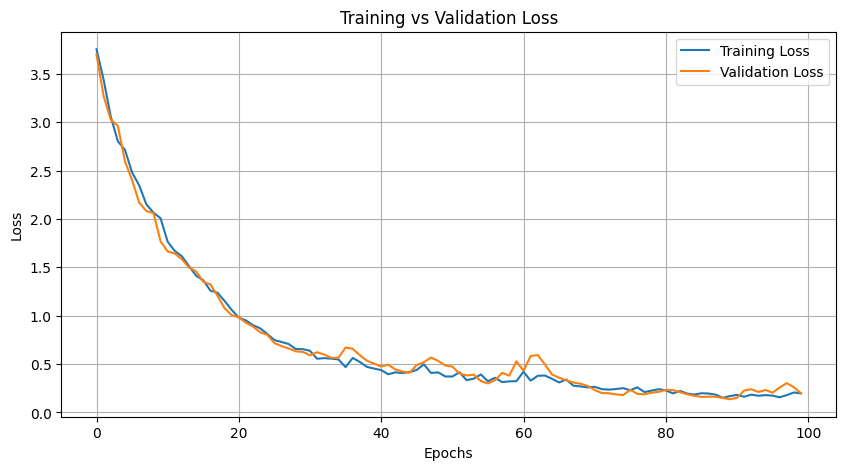

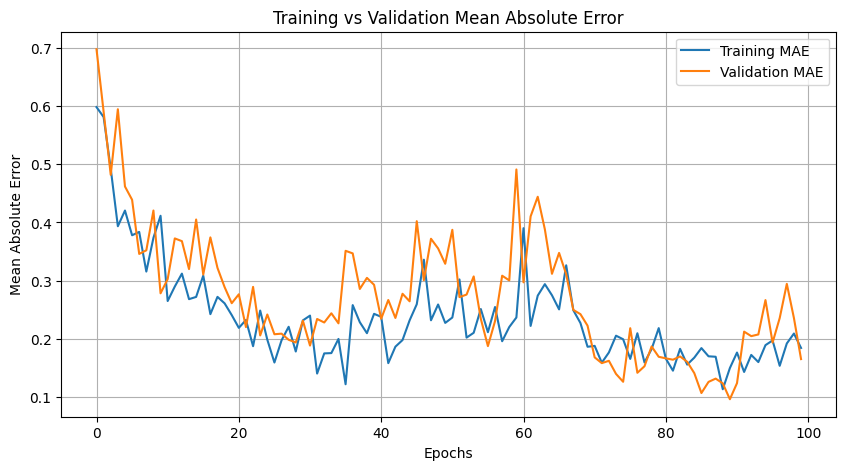

In [ ]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training vs validation MAE (or another metric)
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


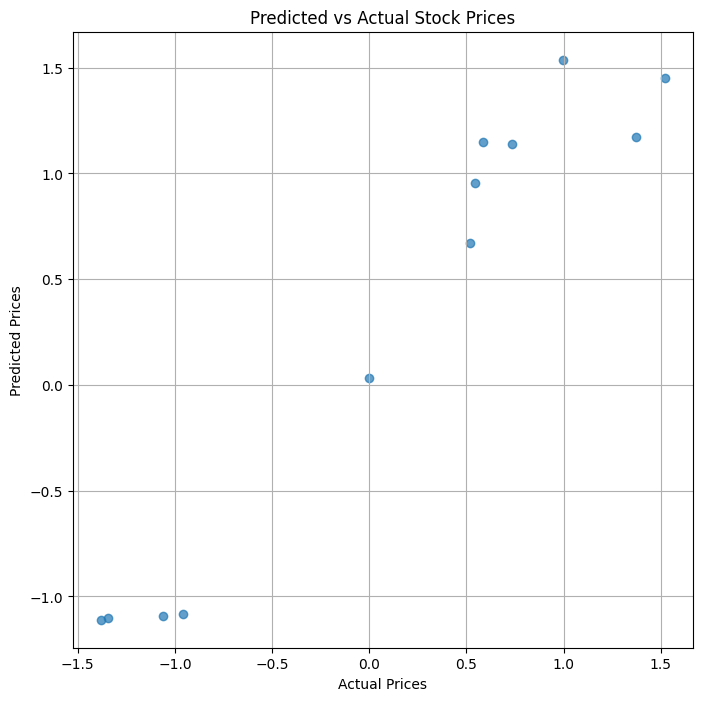

In [ ]:
# Get predictions for the test set
predictions = model.predict([X_news_test, X_news_mask_test, X_historical_test])

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.7)
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()


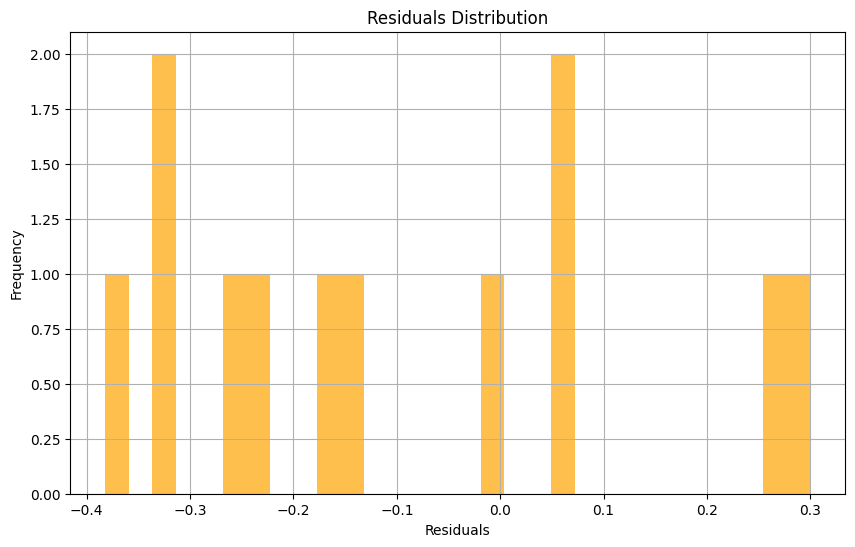

In [ ]:
# Calculate residuals
residuals = y_test - predictions.flatten()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='orange')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


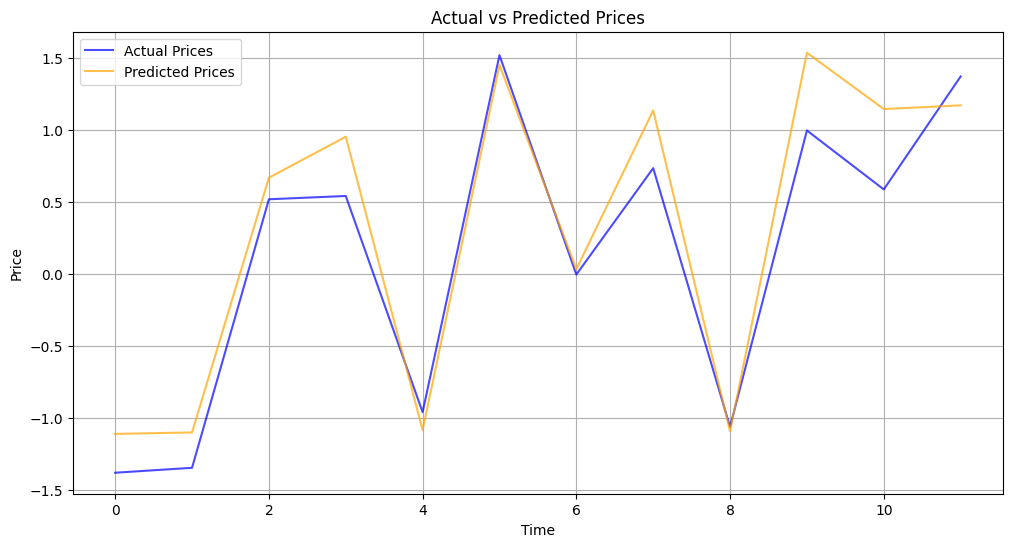

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict([X_news_test, X_news_mask_test, X_historical_test]).flatten()

# Plot the Actual vs Predicted graph
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color="blue", alpha=0.7)
plt.plot(y_pred, label="Predicted Prices", color="orange", alpha=0.7)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


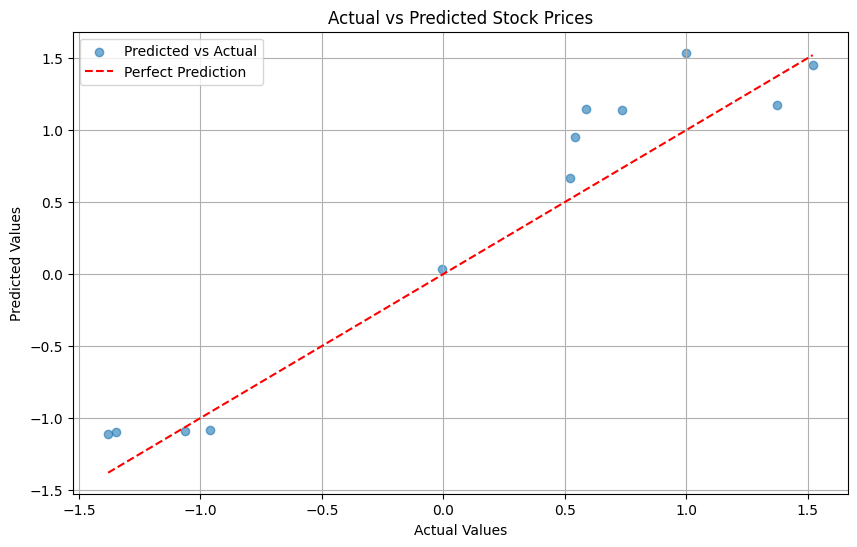

In [ ]:
# Make predictions on the test set
predictions = model.predict([X_news_test, X_news_mask_test, X_historical_test])
predictions = predictions.flatten()  # Flatten predictions

# Actual values
actual = y_test

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(actual, predictions, alpha=0.6, label="Predicted vs Actual")
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color="red", linestyle="--", label="Perfect Prediction")  # Reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("multimodal_stock_price_model.keras")


In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer

# Register custom objects
custom_objects = {"FinBERTLayer": FinBERTLayer, "build_historical_transformer": build_historical_transformer}

# Load the model
model = tf.keras.models.load_model("multimodal_stock_price_model.keras", custom_objects=custom_objects)

# Load FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")


Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer

# Load FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

def preprocess_news(news_csv):
    """Loads news CSV and tokenizes the latest news using FinBERT."""
    df = pd.read_csv(news_csv)

    # Assuming 'News' is the column with news
    latest_news = df['News'].iloc[0]  # Take the latest news item

    encoded = tokenizer(latest_news,
                        padding="max_length",
                        truncation=True,
                        max_length=512,
                        return_tensors="np")

    return encoded["input_ids"][0], encoded["attention_mask"][0]  # Remove extra batch dim

def preprocess_historical_data(stock_csv):
    """Loads stock CSV, keeps last 90 days, and formats it correctly."""
    df = pd.read_csv(stock_csv)

    # Convert 'Date' column to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').tail(90)  # Keep last 90 days

    # Compute mean and std for denormalization
    price_mean = df['Price'].mean()
    price_std = df['Price'].std()

    # Normalize data (excluding Date column)
    df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()

    # Padding with zeros if less than 90 days
    if len(df) < 90:
        padding_shape = (90 - len(df), df.shape[1] - 1)  # Exclude 'Date' column
        padding_data = np.zeros(padding_shape)
        padding_df = pd.DataFrame(padding_data, columns=df.columns[1:])  # Exclude 'Date' column
        df = pd.concat([padding_df, df.drop(columns=['Date'])], ignore_index=True)
    else:
        df = df.drop(columns=['Date'])  # If already 90 days, drop 'Date'

    stock_features = df.values  # Get numerical data
    return np.expand_dims(stock_features, axis=0), price_mean, price_std  # Add batch dim, return mean & std

# Load model
#model = tf.keras.models.load_model("multimodal_stock_price_model.keras")

def predict_next_day_price(news_csv, stock_csv):
    """Predicts next-day stock price and converts it back to actual form."""
    # Process news and historical data
    news_input_ids, news_attention_mask = preprocess_news(news_csv)  # Shape: (1, 512)
    historical_data, price_mean, price_std = preprocess_historical_data(stock_csv)  # Shape: (1, 90, 5)

    # Run prediction
    predicted_price = model.predict([np.expand_dims(news_input_ids, axis=0),
                                     np.expand_dims(news_attention_mask, axis=0),
                                     historical_data])

    # Denormalize the predicted price
    actual_price = (predicted_price[0][0] * price_std) + price_mean

    print(f"Predicted Stock Price for the Next Day: {actual_price:.2f}")

# Example usage
predict_next_day_price("/content/SMP NT.csv", "/content/SMP (90 Day).csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Stock Price for the Next Day: 16.43


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objects as go
from transformers import AutoTokenizer

# Load FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

def preprocess_news(news_csv):
    """Loads news CSV and tokenizes the latest news using FinBERT."""
    df = pd.read_csv(news_csv)

    # Assuming 'News' is the column with news
    latest_news = df['News'].iloc[0]  # Take the latest news item

    encoded = tokenizer(latest_news,
                        padding="max_length",
                        truncation=True,
                        max_length=512,
                        return_tensors="np")

    return encoded["input_ids"][0], encoded["attention_mask"][0]  # Remove extra batch dim

def preprocess_historical_data(stock_csv):
    """Loads stock CSV, keeps last 90 days, and formats it correctly."""
    df = pd.read_csv(stock_csv)

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Check if 'Date' exists
    if 'Date' not in df.columns:
        raise KeyError("Column 'Date' not found in CSV. Check the column names:", df.columns)

    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Sort and keep last 90 days
    df = df.sort_values('Date').tail(90)

    # Compute mean and std for denormalization
    price_mean = df['Price'].mean()
    price_std = df['Price'].std()

    # Normalize data (excluding Date column)
    df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()

    # Drop 'Date' but store for later use
    dates = df['Date']
    df = df.drop(columns=['Date'])

    stock_features = df.values
    return np.expand_dims(stock_features, axis=0), price_mean, price_std, dates

# Load model
# model = tf.keras.models.load_model("multimodal_stock_price_model.keras")

def predict_next_day_price(news_csv, stock_csv):
    """Predicts next-day stock price and converts it back to actual form."""
    # Process news and historical data
    news_input_ids, news_attention_mask = preprocess_news(news_csv)  # Shape: (1, 512)
    historical_data, price_mean, price_std, dates = preprocess_historical_data(stock_csv)  # Shape: (1, 90, 5)

    # Run prediction
    predicted_price = model.predict([np.expand_dims(news_input_ids, axis=0),
                                     np.expand_dims(news_attention_mask, axis=0),
                                     historical_data])

    # Denormalize the predicted price
    actual_price = (predicted_price[0][0] * price_std) + price_mean

    print(f"Predicted Stock Price for the Next Day: {actual_price:.2f}")

    # Call plot function
    plot_stock_prices(stock_csv, actual_price)

def plot_stock_prices(stock_csv, predicted_price):
    """Plots historical stock prices and predicted next-day price with visible text annotation."""
    df = pd.read_csv(stock_csv)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').tail(90)

    fig = go.Figure()

    # Add historical prices
    fig.add_trace(go.Scatter(
        x=df['Date'],
        y=df['Price'],
        mode='lines+markers',
        name='Historical Prices'
    ))

    # Add predicted price
    next_date = df['Date'].max() + pd.Timedelta(days=1)
    fig.add_trace(go.Scatter(
        x=[next_date],
        y=[predicted_price],
        mode='markers',
        marker=dict(size=10, color='red'),
        name='Predicted Price'
    ))

    # Add text annotation for predicted price with date
    fig.add_annotation(
        x=next_date,
        y=predicted_price,
        text=f"Predicted price: BDT {predicted_price:.2f}<br> (Date: Jan 01, 2025)",
        showarrow=True,
        arrowhead=2,
        font=dict(size=12, color="black"),
        ax=0,
        ay=-40  # Adjust arrow position
    )

    # Update layout
    fig.update_layout(
        title="Stock Price Prediction (Sumit Power Ltd)",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        template="plotly_white"
    )

    fig.show()



# Example usage
predict_next_day_price("/content/SMP NT.csv", "/content/SMP (90 Day).csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted Stock Price for the Next Day: 16.43


**Jan 01, 2025	14.80	**